## ShakemapSim: Simulate spatially correlated ground-motion intensity measures conditional on recordings 

**Example of the 2023 earthquake at the border of Turkey and Syria**

This notebook shows how to use [ShakemapSim](https://github.com/bodlukas/ground-motion-simulation-shakemap), a tool to generate spatially correlated fields of ground-motion Intensity Measures (IMs) conditional on available recordings from a seismic network.

The generated IM fields are particularly useful for validating and developing models for damage, loss and recovery predictions using data gathered after an event.

In this notebook, we explain how to:
1. import earthquake rupture information and recorded ground-motion IMs,
2. specify (and customize) which ground-motion models and spatial correlation models are used to compute the shakemap,
3. specify sites at which we would like to predict ground-motion IMs,
4. use ShakemapSim to predict and sample ground-motion IMs. 

The points above are illustrated in two example regions located in the Turkish province of Hatay ([wikipedia](https://en.wikipedia.org/wiki/Hatay_Province)). The ground motions IMs considered are those currently available in the ground motion recording database. They are: 'PGA', 'SA(0.3)', 'SA(1.0)’ and 'SA(3.0)’. All accelerations are in units of g (not %g !).

If you use this tool in your work please please cite it as:
> Bodenmann, Lukas, and Stojadinović, Božidar. (2023). ShakemapSim: Simulate spatially correlated ground-motion intensity measures conditional on recordings (v1.0). Zenodo. https://doi.org/10.5281/zenodo.7646888

For further information please refer to the readme file and the extensive documentation of the source files in the [repo](https://github.com/bodlukas/ground-motion-simulation-shakemap).

The next three cells set up the required tools in colab, which may take 2 to 3 minutes.

In [1]:
%%capture
!pip install openquake.engine==3.15.0

In [2]:
# Clone the GitHub repo
%%capture
%cd /tmp
%rm -rf /tmp/test
!git clone https://github.com/bodlukas/ground-motion-simulation-shakemap.git \
  /tmp/test
%cd /tmp/test

In [3]:
import numpy as np
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import openquake.hazardlib as oq
plt.style.use('ggplot')
path_data = 'data' + os.sep

## Import rupture information

For now we include two options to specify the rupture: 

1) **Shakemap rupture** json file provided with the USGS shakemap version 12 of this event. The `rupture.json` file was downloaded on 2023-14-02 at 14:55 CET from [here](https://earthquake.usgs.gov/earthquakes/eventpage/us6000jllz/shakemap/metadata).  

2) **Finite fault** provided by the USGS ([see here](https://earthquake.usgs.gov/earthquakes/eventpage/us6000jllz/finite-fault)). The currently used values stem from version 2 of the finite fault model.

For both methods: Check for new updates before applying!

We model the rupture as a collection of multiple planar rupture surfaces. This is done via the `get_planarsurface` method. For significant changes in the rupture information and geometry, one might has to adapt this method. 

In the following examples we'll use the shakemap rupture.

In [4]:
from utils import get_planarsurface
Point = oq.geo.point.Point
BaseRupture = oq.source.rupture.BaseRupture

option_rupture = 'shakemap' # 'shakemap' or 'finitefault' as stated above

f = open(path_data + 'rupture.json')
rup_temp = json.load(f)
f.close()

if option_rupture == 'shakemap':
    rupture_surface = get_planarsurface(rup_temp['features'][0]['geometry'])
elif option_rupture == 'finitefault':
    from utils import get_finite_fault
    rupture_surface = get_planarsurface(get_finite_fault())
rup_temp = rup_temp['metadata']
rupture = BaseRupture(mag = rup_temp['mag'], rake = rup_temp['rake'], 
                    tectonic_region_type = 'Active Shallow Crust', 
                    hypocenter = Point(longitude = rup_temp['lon'], 
                                        latitude = rup_temp['lat'],
                                        depth = rup_temp['depth']),
                    surface = rupture_surface)

## Import station list

For now we include the station list provided by the USGS shakemap system. The `stationlist.json` file was downloaded on 2023-14-02 at 14:55 CET from [here](https://earthquake.usgs.gov/earthquakes/eventpage/us6000jllz/shakemap/metadata). Check for new updates before applying.

The method `read_stationlist` collects the longitude, latitude and vs30 values for each station, as well as the recorded IM values in two horizontal directions.

In [5]:
from utils import read_stationlist

f = open(path_data + 'stationlist.json')
stations_temp = json.load(f)
stations_temp = stations_temp['features']
f.close()

dfstations = read_stationlist(stations_temp)
dfstations

,id,code,longitude,latitude,vs30,sa(0.3)_E,sa(1.0)_E,sa(3.0)_E,pga_E,pgv_E,sa(0.3)_N,sa(1.0)_N,sa(3.0)_N,pga_N,pgv_N
0,KO.ARPRA,ARPRA,38.3356,39.0929,878.13,0.115508,0.060479,0.049121,0.044765,12.7289,0.086159,0.102017,0.044014,0.050168,10.1561
1,KO.CMRD,CMRD,34.9902,37.6623,762.04,0.014220,0.008482,0.004580,0.004960,2.6909,0.018498,0.013853,0.007351,0.007499,3.5835
2,KO.KHMN,KHMN,37.1574,37.3916,313.91,0.706746,0.601586,0.331964,0.530371,100.0960,0.630066,0.486919,0.232605,0.629572,80.9896
3,KO.KOZK,KOZK,34.8680,39.2101,543.84,0.014698,0.029326,0.011246,0.010661,4.7466,0.013072,0.031914,0.010040,0.010260,5.2272
4,KO.KRTS,KRTS,35.3750,36.5730,331.46,0.173221,0.079116,0.034312,0.042816,15.1153,0.166746,0.051626,0.024567,0.055023,12.5387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,KO.ERBG,ERBG,36.6768,40.7120,900.00,0.003421,0.008361,0.006608,0.003214,1.5119,0.004366,0.012170,0.006565,0.004122,1.1194
256,KO.GUMT,GUMT,39.4780,40.4665,900.00,0.003795,0.004971,0.004307,0.002550,1.1218,0.003197,0.004348,0.002680,0.002145,0.8801
257,KO.KRMN,KRMN,33.2636,37.1740,381.95,0.010515,0.014647,0.003190,0.005408,1.1971,0.009231,0.014977,0.006356,0.006946,1.2500
258,KO.KYHL,KYHL,37.8955,40.3244,826.26,0.009267,0.022780,0.008636,0.007456,1.9005,0.009624,0.009802,0.005788,0.005208,1.3886


The following figure shows the rupture and all stations. To minimize additional dependencies, I do not use any specific tools for proper geographic plotting. Please excuse the quality of the figures.

Dimensions of shown map in km:
1000.0 x 758.0


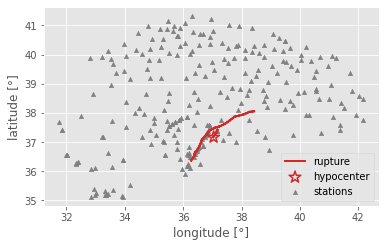

In [6]:
from utils import get_extent_size
fig, ax = plt.subplots()
for i, surf in enumerate(rupture_surface.surfaces):
    if i == 0: label = 'rupture'
    else: label = None
    lons, lats = surf.get_surface_boundaries()
    ax.plot(lons, lats, color='tab:red', lw=2,zorder=2, label=label)
ax.scatter(rupture.hypocenter.longitude, rupture.hypocenter.latitude, marker='*', color='none', 
           edgecolor='tab:red', s=150, zorder=2, label='hypocenter', lw=1.5)
ax.scatter(dfstations['longitude'], dfstations['latitude'], marker='^', s=20, color='gray', alpha=1, zorder=1,label='stations')
ax.set_aspect('equal')
ax.set_xlabel('longitude [°]')
ax.set_ylabel('latitude [°]')
ax.legend()
extent = get_extent_size(ax)
print('Dimensions of shown map in km:')
print(str(extent[0]) + ' x ' + str(extent[1]))

## Specify model components and intensity measure of interest

In the following we specify the different modules required to compute the shakemap. 
1. **IM of interest**: Specify intensity measure by setting the value of the string `im_string` to one of the following:  'PGA', 'SA(0.3)', 'SA(1.0)’ or 'SA(3.0)’. NOTE: The limitation to these measures is due to the availability in the `stationlist.json` file imported from USGS's shakemap system.  
2. The **ground-motion model**: I use a small wrapper `GMM` around the openquake implementation of the GMM. We tested the method with the two GMMs (`AkkarEtAlRjb2014` and `CauzziEtAl2014`) which together account for 70% of the logic-tree weights in the USGS shakemap system for the considered event. Both of these GMMs are defined for the average horizontal value (e.g., the geometric mean of the recorded IMs in two horizontal directions). 
3. The **spatial-correlation model**: Here I use three different models. The model `EspositoIervolino2012esm` was derived from European ground-motion data. The model `HeresiMiranda2019` was derived for a worldwide dataset and has a slightly different functional form. The recently published model of `BodenmannEtAl2022` was also estimated from a worldwide dataset, but accounts for soil and path effects (in addition to spatial proximity). Amongst the three models `EspositoIervolino2012esm` assigns strongest correlations for close sites.
4. We use a small wrapper `Stations` which takes information from the dataframe shown above.
5. Finally, we assemble the defined modules and initialize a `Shakemap` object. This object contains all methods to perform the computations and the sampling. See also the documentation in `modules/shakemap.py`. 

References to the original papers can be found in the corresponding documentations.

In [7]:
from modules.shakemap import Stations, GMM, Sites, Shakemap
from modules.spatialcorrelation import (HeresiMiranda2019, 
                                        EspositoIervolino2012esm,
                                        BodenmannEtAl2022)

# 1) Specify considered intensity measure 
# ---------
im_string = 'SA(1.0)' # one of ['PGA', 'SA(0.3)', 'SA(1.0)', 'SA(3.0)']

# 2) Specify Ground-Motion model
# ---------
gmm = GMM(oq.gsim.cauzzi_2014.CauzziEtAl2014(), im_string)
# gmm = GMM(oq.gsim.akkar_2014.AkkarEtAlRjb2014(), im_string)

# 3) Specify Correlation model
# ---------
scm = EspositoIervolino2012esm(im_string)
# scm = HeresiMiranda2019(im_string)
# scm = BodenmannEtAl2022(im_string, rupture)

# 4) Wrap stations
# ---------
stations = Stations(dfstations, im_string)

# 5) Combine model components
# ---------
shakemap = Shakemap(Rupture = rupture, 
                    Stations = stations,
                    GMM = gmm,
                    SCM = scm)

## How to compute predictions and generate samples

**How to specify sites**

The specification of sites is straightforward and requires their longitudes and latitudes in degrees, as well as vs30 values in m/s.

In [8]:
dfsites = pd.DataFrame(data={'longitude': [36.51, 36.62], 
                             'latitude': [37.01, 37.10],
                             'vs30': [210, 500]})
# Initialize Sites object
sites = Sites(dfsites)

**Predictions conditional on recorded IMs**

Use the function `predict_logIM(sites)` to predict logIM at the chosen sites conditional on recordings from seismic stations. If no other arguments are provided, the function computes the mean and variance at each site. If you specify `full_cov=True`, the function computes the full covariance matrix between both sides. See the example below.

In [9]:
np.set_printoptions(precision=3)
print('Predicted parameters conditional on recorded IMs\n')
# Predict mean and variance of logIM at the two sites 
mu, var = shakemap.predict_logIM(sites)
print(f'Mean of logIM \n{mu.squeeze()}\n')
print(f'Variance (diagonal of covariance matrix)\n{var.squeeze()}\n')

# Predict mean and full covariance matrix of logIM at the two sites 
_, cov_matrix = shakemap.predict_logIM(sites, full_cov = True)
print(f'Covariance matrix\n{cov_matrix.squeeze()}\n')

Predicted parameters conditional on recorded IMs

Mean of logIM 
[-0.352 -0.665]

Variance (diagonal of covariance matrix)
[0.426 0.213]

Covariance matrix
[[0.426 0.025]
 [0.025 0.213]]



**Predictions neglecting recorded IMs**

If we additionally specify `conditional=False`, the function `predict_logIM` computes predictions without taking seismic recordings into account. See the example below.

In [10]:
print('Predicted parameters neglecting recorded IMs\n')
# Predict mean and variance of logIM at the two sites 
mu, var = shakemap.predict_logIM(sites, conditional = False)
print(f'Mean of logIM \n{mu.squeeze()}\n')
print(f'Variance (diagonal of covariance matrix)\n{var.squeeze()}\n')

# Predict mean and full covariance matrix of logIM at the two sites 
_, cov_matrix = shakemap.predict_logIM(sites, full_cov = True, conditional = False)
print(f'Covariance matrix\n{cov_matrix.squeeze()}')

Predicted parameters neglecting recorded IMs

Mean of logIM 
[-0.164 -0.553]

Variance (diagonal of covariance matrix)
[0.747 0.747]

Covariance matrix
[[0.747 0.365]
 [0.365 0.747]]


**Sampling conditional on recorded IMs**

Use the function `sample_logIM(sites, nsamples)` to generate `nsamples` correlated samples of logIM at the specified sites. If you additionally specify `full_cov=False`, the function will generate independent samples. 

For simulations that do not take into account recordings from seismic stations, simply specify `conditional=False`, as illustrated above.

In [11]:
print('Sample log(im) conditional on recorded IMs\n')
# Generate correlated samples
sam = shakemap.sample_logIM(sites, nsamples=1, full_cov = True, seed=0)
print(f'Correlated samples of logIM\n{sam.squeeze()}\n')

# Generate independent samples
sam = shakemap.sample_logIM(sites, nsamples=1, full_cov = False, seed=0)
print(f'Independent samples of logIM\n{sam.squeeze()}\n')

Sample log(im) conditional on recorded IMs

Correlated samples of logIM
[-0.427 -0.734]

Independent samples of logIM
[-0.27  -0.726]



## Example 1: Maps of conditional IM distribution parameters

This example focuses on a region extending over 37km x 35km. The region is located in the Turkish province of Hatay, which is at the south-western end of the rupture (shown with the black square below). The objective is to compute the spatial distribution of ground motion IMs in terms of the marginal parameters of their predictive distributions, i.e., the mean and the variance (or standard deviation) at each site. The IM of interest in this example is SA(1.0) (as defined above).

We first load the csv file which contains vs30 values at a longitude-latitude grid in this region.

In [12]:
dfsites = pd.read_csv(path_data + 'grid_example.csv')
print('Number of grid points: ' + str(len(dfsites)))
sites = Sites(dfsites, ['longitude', 'latitude', 'vs30'])

Number of grid points: 30042


Dimensions of shown map in km:
178.0 x 278.0


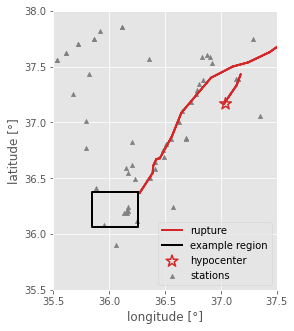

In [13]:
fig, ax = plt.subplots(figsize=(4,7))
for i, surf in enumerate(rupture_surface.surfaces):
    if i == 0: label = 'rupture'
    else: label = None
    lons, lats = surf.get_surface_boundaries()
    ax.plot(lons, lats, color='tab:red', lw=2,zorder=2, label=label)
ax.scatter(rupture.hypocenter.longitude, rupture.hypocenter.latitude, marker='*', color='none', 
           edgecolor='tab:red', s=150, zorder=2, label='hypocenter', lw=1.5)
ax.scatter(dfstations['longitude'], dfstations['latitude'], marker='^', s=20, color='gray', alpha=1, zorder=1,label='stations')
lons_bbox, lats_bbox = sites.get_bbox()
ax.plot(lons_bbox, lats_bbox, color='black', lw=2, label='example region')
ax.set_xlim([35.5, 37.5]); ax.set_ylim([35.5, 38]); ax.set_aspect('equal')
ax.set_xlabel('longitude [°]'); ax.set_ylabel('latitude [°]')
ax.legend()
extent = get_extent_size(ax)
print('Dimensions of shown map in km:')
print(str(extent[0]) + ' x ' + str(extent[1]))

**Overview and soil conditions**

The figure below plots the vs30 values in the considered region. Those values are taken from USGS (https://earthquake.usgs.gov/data/vs30/).

The black square shows the region that will be examined in Example 2. Gray triangles indicate seismic stations.

Dimensions of shown map in km:
37.0 x 35.0


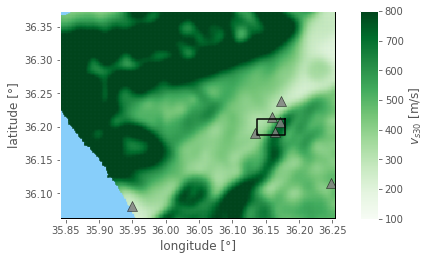

In [14]:
# Add bbox for example 2
lons_bbox2 = np.array([36.17847587, 36.17847587, 36.13702504, 36.13702504, 36.17847587])
lats_bbox2 = np.array([36.21199931, 36.18703261, 36.18703261, 36.21199931, 36.21199931])

fig, ax = plt.subplots(figsize=(6,3.5), constrained_layout=True)
for surf in rupture_surface.surfaces:
    lons, lats = surf.get_surface_boundaries()
    ax.plot(lons, lats, color='tab:red', lw=2, zorder=2)
im = ax.scatter(dfsites.longitude, dfsites.latitude, c=dfsites.vs30.values, 
                vmin=100, vmax=800, cmap=plt.get_cmap('Greens'), s=2, marker='s')
ax.set_aspect('equal');  ax.grid(False)
lons_bbox, lats_bbox = sites.get_bbox()
ax.scatter(dfstations['longitude'], dfstations['latitude'], marker='^', s=100, color='gray', alpha=0.85, edgecolor='black')
ax.plot(lons_bbox, lats_bbox, color='black', lw=2)
ax.plot(lons_bbox2, lats_bbox2, color='black', lw=1.5, ls='-', label = 'Example 2')
ax.set_xlim([lons_bbox.min(), lons_bbox.max()]); ax.set_ylim([lats_bbox.min(), lats_bbox.max()])
plt.colorbar(im, label='$v_{s30}$ [m/s]')
ax.set_xlabel('longitude [°]'); ax.set_ylabel('latitude [°]')
ax.set_facecolor('lightskyblue')
extent = get_extent_size(ax)
print('Dimensions of shown map in km:')
print(str(extent[0]) + ' x ' + str(extent[1]))

**Compute conditional IM distribution parameters**

For these maps, we focus on the marginal parameters, which means the mean and variance (or standard deviation) at each site. Thus, we specify `full_cov=False`.

Note that we consider more than 30'000 sites in this example, and with a full computation of the covariance matrix we would most probably run into memory issues. The full computation and sampling procedure is shown in Example 2 for a smaller number of sites.

In [15]:
mu, var = shakemap.predict_logIM(sites, conditional=True, full_cov=False)

Dimensions of shown map in km:
37.0 x 35.0


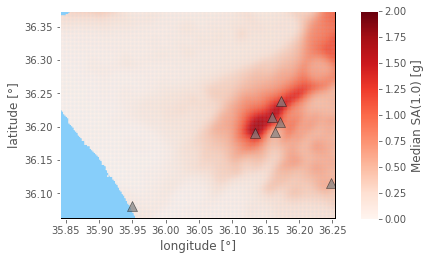

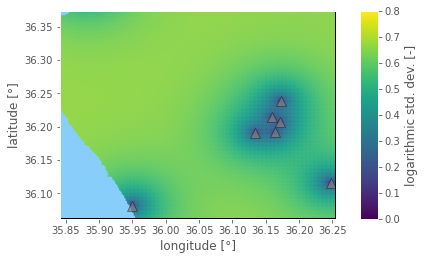

In [16]:
msize = 1.5
# Specify values to plot: Median IM and logarithmic std. dev.
vals = [np.exp(mu), np.sqrt(var)]
cmaps = [plt.get_cmap('Reds'), None]
clims = [(0, 2), (0, 0.8)]
labels = ['Median ' + im_string + ' [g]', 'logarithmic std. dev. [-]']

for i in range(2):
  fig, ax = plt.subplots(figsize=(6,3.5), constrained_layout=True)
  im = ax.scatter(dfsites.longitude, dfsites.latitude, c=vals[i], 
                  vmin=clims[i][0], vmax=clims[i][1], s=msize, cmap=cmaps[i])
  ax.set_aspect('equal')
  for surf in rupture_surface.surfaces:
      lons, lats = surf.get_surface_boundaries()
      ax.plot(lons, lats, color='black', lw=2,zorder=2, label=label)
  ax.scatter(dfstations['longitude'], dfstations['latitude'], marker='^', 
             s=100, color='gray', alpha=0.7, edgecolor='black')
  lons_bbox, lats_bbox = sites.get_bbox()
  ax.plot(lons_bbox, lats_bbox, color='black', lw=2)
  ax.set_xlim([lons_bbox.min(), lons_bbox.max()]); 
  ax.set_ylim([lats_bbox.min(), lats_bbox.max()])
  ax.grid(False)
  plt.colorbar(im, label=labels[i])
  ax.set_xlabel('longitude [°]'); ax.set_ylabel('latitude [°]')
  ax.set_facecolor('lightskyblue')
  if i == 0:
    extent = get_extent_size(ax)
    print('Dimensions of shown map in km:')
    print(str(extent[0]) + ' x ' + str(extent[1]))
  else: plt.show()

## Example 2: Simulate correlated ground-motion IMs conditional on recordings

The csv file `buildings_example.csv` contains the location of more than 14000 buildings in the city of Antakya, Turkey (small black dots in the figure below). The buildings are distributed over an area of 4 x 3 km. The goal is to compute samples of the IM of interest at the sites where the buildings are located. The IM of interest in this example is SA(1.0) (as defined above).

The building data was derived from a worldwide building footprint dataset offered by [Microsoft](https://github.com/microsoft/GlobalMLBuildingFootprints).

For this illustration, we randomly sample 2000 buildings from this dataset (orange dots in the figure below).

In [17]:
# gain memory
if 'mu' in locals(): del mu
if 'var' in locals(): del var

dfsites = pd.read_csv(path_data + 'buildings_example.csv')
sites = Sites(dfsites)
lons_bbox, lats_bbox = sites.get_bbox()
dfsites_sim = dfsites.sample(n=2000, random_state=91)
sites = Sites(dfsites_sim)

Dimensions of shown map in km:
5.0 x 4.0


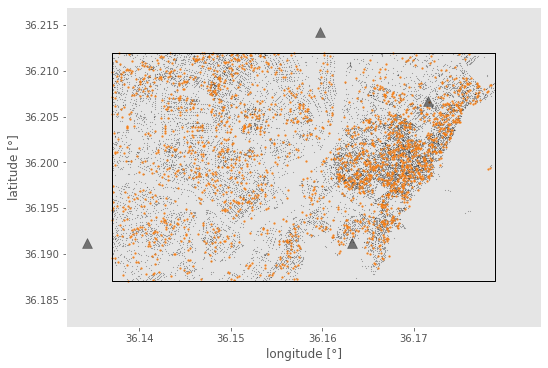

In [18]:
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
im = ax.scatter(dfsites.longitude, dfsites.latitude, color='black', s=0.5, alpha=0.25)
im = ax.scatter(dfsites_sim.longitude, dfsites_sim.latitude, color='tab:orange', s=3, alpha=0.75)
ax.set_aspect('equal')
for surf in rupture_surface.surfaces:
    lons, lats = surf.get_surface_boundaries()
    ax.plot(lons, lats, color='black', lw=2,zorder=2, label=label)
ax.scatter(dfstations['longitude'], dfstations['latitude'], marker='^', s=100, color='black', alpha=0.5, edgecolor='black')
ax.plot(lons_bbox, lats_bbox, color='black', lw=1)
ax.set_xlim([lons_bbox.min()-0.005, lons_bbox.max()+0.005]); ax.set_ylim([lats_bbox.min()-0.005, lats_bbox.max()+0.005])
ax.grid(False)
ax.set_xlabel('longitude [°]'); ax.set_ylabel('latitude [°]')
ax.set_xticks(np.arange(36.140, 36.180, 0.01))
extent = get_extent_size(ax)
print('Dimensions of shown map in km:')
print(str(extent[0]) + ' x ' + str(extent[1]))

**Visual comparison of two simulated fields**

The function `sample_logIM` is used to generate spatially correlated fields of logarithmic IM values. The IM of interest in this example is SA(1.0) (as defined above).

In [19]:
sim_logim = shakemap.sample_logIM(sites, nsamples=2, conditional=True, seed=20)

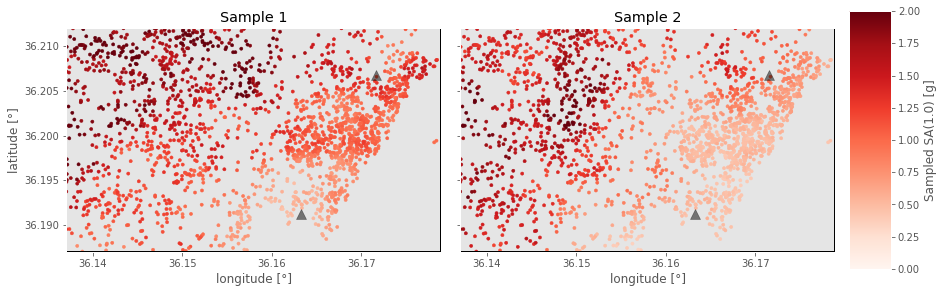

In [20]:
fig, axs = plt.subplots(1,2, figsize=(13,4), sharey=True, constrained_layout=True)
for i, ax in enumerate(axs):
    im = ax.scatter(dfsites_sim.longitude, dfsites_sim.latitude, c=np.exp(sim_logim)[i,:], vmin=0, vmax=2, 
                    s=10, cmap=plt.get_cmap('Reds'))
    ax.set_aspect('equal')
    for surf in rupture_surface.surfaces:
        lons, lats = surf.get_surface_boundaries()
        ax.plot(lons, lats, color='black', lw=2,zorder=2, label=label)
    ax.scatter(dfstations['longitude'], dfstations['latitude'], marker='^', s=100, color='black', alpha=0.5, edgecolor='black')
    ax.plot(lons_bbox, lats_bbox, color='black', lw=2)
    ax.set_xlim([lons_bbox.min(), lons_bbox.max()]); ax.set_ylim([lats_bbox.min(), lats_bbox.max()])
    ax.grid(False)
    if i==1: plt.colorbar(im, label='Sampled ' + im_string + ' [g]')
    if i==0: ax.set_ylabel('latitude [°]')
    ax.set_xlabel('longitude [°]'); 
    ax.set_xticks(np.arange(36.140, 36.180, 0.01))
    ax.set_title('Sample ' + str(i+1))
plt.show()

**Compute proportions of sites where a threshold IM value was exceeded**

For regional damage, loss and recovery studies, it is of interest to statistically estimate the number of building sites where the IM of interest exceeded a given threshold. 

For the same 2000 building sites, we will now compute the probability distribution of the proportion of sites where the IM of interest exceeded a certain threshold. First, we sample a large number (10000 in this example) of ground-motion fields (like those in the figure above). Then, for each sample, we count the number of sites where the IM of interest threshold was exceeded and divide by the total number of sites to get the proportion of sites. In this example, the IM of interest is SA(1.0) (as defined above) and its threshold is set to 0.75g (see below). 

In [21]:
nsamples = 10000
threshold = 0.75 # unit g !
sim_logim = shakemap.sample_logIM(sites, nsamples=nsamples, 
                                   conditional=True, seed=31)
prop_exceedance = np.sum((np.exp(sim_logim) > threshold), axis=1) / len(dfsites_sim)

We plot a histogram of the 10000 samples, and compute their 5% and the 95% quantiles. The figure and the stated results indicate that the **remaining uncertainty in the ground-motion intensity measure** is still substantial: The results in this example suggest a 90% credibility that the proportion of sites where the threshold was exceeded is **between 62.2 and 92.4%**. This is despite the facts that the considered buildings are distributed over a very small area (4 x 3 km), and that there are two seismic stations in this region as well as an additional two stations very close to this region.

Note that this finding is for the selected region, for the IM SA(1.0), an IM threshold of 0.75g, as well as for one specific ground-motion model and one specific spatial correlation model. Feel free to re-run the code using the different implemented models (or implement your own models), and vary the region, IM and IM threshold values. 

{'mean': 0.782, '5,95% quantiles': (0.622, 0.924)}


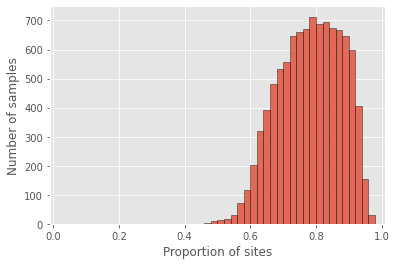

In [22]:
res_metrics = {'mean': np.round(np.mean(prop_exceedance),3), 
               '5,95% quantiles': tuple(np.round(np.quantile(prop_exceedance, [0.05, 0.95]),3))}
print(res_metrics)
fig, ax = plt.subplots(figsize=(6,4))
bw = 0.02
bins = np.arange(0, 1+2*bw, bw)
ax.hist(prop_exceedance,bins,alpha=0.8, edgecolor='black')
ax.set_ylabel('Number of samples')
ax.set_xlabel('Proportion of sites')
ax.set_xlim([-0.01, 1.01])
plt.show()